In [1]:
%matplotlib inline

width = 6
height = 3
import matplotlib
matplotlib.rcParams['figure.figsize'] = [width, height]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmmlearn

from hmmlearn.hmm import GaussianHMM

In [2]:
print(pd.__version__)
print(np.__version__)
print(hmmlearn.__version__)

1.2.2
1.20.1
0.2.5


## Look at the data

In [3]:
nile = pd.read_csv("Nile.csv", index_col = 0)

In [4]:
nile.head()

,year,val
1,1871,1120
2,1872,1160
3,1873,963
4,1874,1210
5,1875,1160


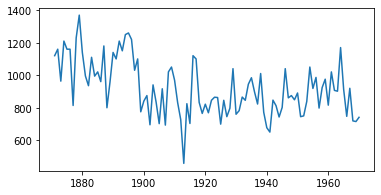

In [5]:
plt.plot(nile.year, nile.val)

Can be stipulated that may be one state change between 1900 and 1920

For modeling Rivers systems there are two states: High Flow and Low Flow
At Some point it's in one regime/states and at some point it switches to another but it's not deterministic (given an input it always return the same output for that input), it's a stochastic switching

## Let's take a look at the hmmlearn API

The API require two dimensions for their input
Obs= Array with two dimensions  is a Matrix

In [6]:
vals = np.expand_dims(nile.val.values, 1)
n_states = 2
model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
hidden_states = model.predict(vals)

The Model Just Need the number of states (High and Low) and the number of iterations to fit the data (vals)
model.predict() will return the "predicted" state for each value in the series, in other words, no forecasting. It returns a Numpy Array but the values doesn't mean anything

In [7]:
np.bincount(hidden_states)

array([28, 72], dtype=int64)

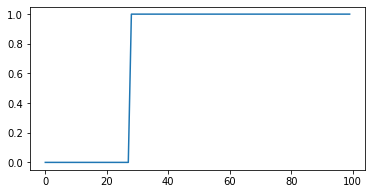

In [8]:
plt.plot(hidden_states)

The model prediction conffirmed what was suposed before and there was a change of state between 1900 and 1920 or 20/40

## Exercise: how can we package this more conveniently?

In [9]:
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    # Info about Gaussian Distribution
    # Squeeze oposite of expand_dims
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    #Transition Matrix
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    # re-order parameters in ascending order of mean of underlying distribution
    # process of Re-ordering the Hidden States
    #argsort return sorting index array
    idx      = np.argsort(mus)
    mus      = mus[idx]
    sigmas   = sigmas[idx]
    transmat = transmat[idx, :][:, idx]
    
    state_dict = {}
    states = [i for i in range(n_states)]
    for i in idx:
        state_dict[i] = states[idx[i]]
    
    relabeled_states = [state_dict[h] for h in hidden_states]
    return (relabeled_states, mus, sigmas, transmat, model)

### OBS: Data must be reordered before Plotting

In [10]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values,2)

[1097.15261711  850.75596948]
[133.74749638 124.44593534]


In [11]:
def plot_states(ts_vals, states, time_vals):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Year)')
    ax1.set_ylabel('Nile river flow',         color=color)
    ax1.plot(time_vals, ts_vals,      color=color)
    ax1.tick_params(axis='y',            labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states,     color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

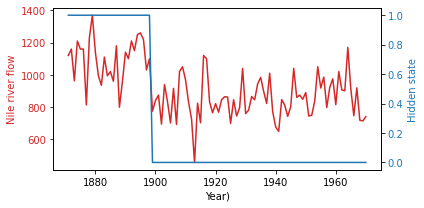

In [12]:
plot_states(nile.val, hidden_states, nile.year)

## Exercise: how might we be able to plot this more sensibly?

Can be possible that the first state in the plot above is an anomaly and doesn't describe the real dynamic of the river. So, may be interesting to analyze the data without the time including this first state, in other words, exclude data before 1900 or the first 20 values.

In [13]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values[28:],2)

[937.46158761 792.26463809]
[110.56877622  95.06214029]


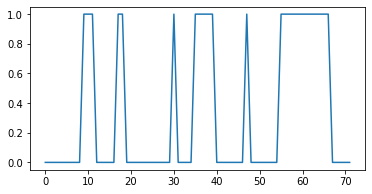

In [14]:
plt.plot(hidden_states)

Another Ideia is to insert another state into the model

In [15]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values,3)

[ 884.82315224  796.01723512 1097.27279934]
[138.785672    67.16297958 133.03503832]


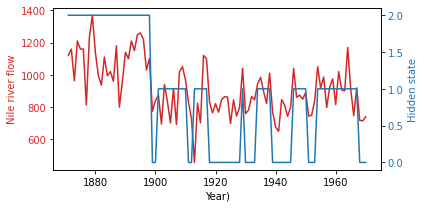

In [16]:
plot_states(nile.val, hidden_states, nile.year)

In [17]:
# Mean Value Of each State
mus

array([ 796.01723512,  884.82315224, 1097.27279934])

In [18]:
np.set_printoptions(precision = 3, suppress = True)
transmat

array([[0.509, 0.491, 0.   ],
       [0.304, 0.696, 0.   ],
       [0.036, 0.   , 0.964]])

## Exercise: generate new synthetic data from the model and then fit it with a fresh HMM model

#### Easy to sample from an existing HMM model

In [25]:
# generate "fake" training data
training1, states1 = model.sample(100)
print("Transition matrix before training: \n", transmat)

# train
hidden_states2, mus2, sigmas2, transmat2, model2 = fitHMM(training1, 3)
print("Transition matrix after training: \n", transmat2)

Transition matrix before training: 
 [[0.509 0.491 0.   ]
 [0.304 0.696 0.   ]
 [0.036 0.    0.964]]
[1005.206  773.93  1130.274]
[ 63.637  75.037 108.947]
Transition matrix after training: 
 [[0.787 0.213 0.   ]
 [0.078 0.256 0.666]
 [0.163 0.452 0.384]]


In [26]:
def plot_states_no_time(ts_vals, states):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Time)')
    ax1.set_ylabel('Value',        color=color)
    ax1.plot(ts_vals,              color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(states,        color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

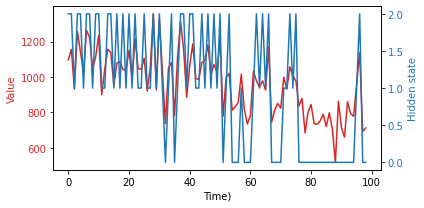

In [27]:
plot_states_no_time(training1[1:100], hidden_states2[1:100])

When fitting the same Model to a different dataset, it will appear a very different model because one of the states (Outlier one) is not present 